In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

# Graphic libraries

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1, grid=False)



from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')
import stan_utility

#import arviz as az
red = '#D62828'
orange = '#F77F00'
yellow = '#FCBF49'
dark = '#003049'
dark_highlight= '#002437'
light = '#EAE2B7'
light_highlight='#C2BDA2'



In [2]:
def phi(L,alpha, L_min):
     return alpha*L_min**alpha / L**(alpha+1)
    

In [3]:
def dNdV(z, r0, rise, decay , peak):
    top = 1 + rise * z
    bottom = 1+np.power(z/peak,decay)
    
    return r0 * top/bottom


def dVdz(z):
    
    return 4*np.pi * (z+1)**2


def dNdz(z, r0, rise, decay , peak):
    
    return dNdV(z, r0, rise, decay , peak) * dVdz(z)

In [4]:


def draw_zs(r0, rise, decay , peak, zmax, size):
    zs = np.linspace(0, zmax, 10000)
    dndzs = dNdz(zs,r0, rise, decay , peak)
    ymax = np.max(dndzs)
    
    zout = []
    for i in range(size):
        flag = True
        while flag:
            y = np.random.uniform(low=0, high=ymax)
            z = np.random.uniform(low=0, high=zmax)
            if y < dNdz(z, r0, rise, decay , peak):
                zout.append(z)
                flag = False
                  
    return np.array(zout)

In [5]:
def draw_luminosity(alpha, L_min, size=1):
    
    return  (np.random.pareto(alpha, size) + 1) * L_min

In [6]:
def draw_lobs(L, sigma_L, size=1):
    return np.exp(np.log(L) + sigma_L*np.random.randn(size))

In [7]:
def draw_survey(alpha, L_min, r0, rise, decay , peak ,Fth, zmax,sigma_L):
    
    N = integrate.quad(dNdz,0.,zmax,args=( r0, rise, decay , peak))[0]
    
    n = np.random.poisson(N)

    Ls = draw_luminosity(alpha=alpha, L_min=L_min, size=n)
    zs = draw_zs( r0, rise, decay , peak ,zmax=zmax, size=n)
    
    Lobs = draw_lobs(Ls, sigma_L,size=n)
    
    Fobs = Lobs / (4*np.pi* (zs+1)*(zs+1))
        
    sel = Fobs > Fth
    
    z99obs = np.percentile(zs[sel], 99)
    
   # print(f'99th percentile of observed galaxy redshifts is {z99obs:.2f}')
    n_model = 500
    return dict(L_obs = Lobs[sel],
                z_obs = zs[sel] ,
                Nnobs = sel.shape[0]-sum(sel),
                z= zs,
                Fobs = Fobs,
                sigma_L = sigma_L,
                N=len( Lobs[sel]),
                z_max = zmax,
                boundary = Fth,
                L = Ls,
                Lmodel=np.logspace(np.log10(L_min),3,n_model),
                zmodel=np.linspace(0,zmax,n_model),
                N_model=n_model   
               )
                
                

In [25]:
r0_true = 5E-1
rise_true = 1
decay_true = 3.
peak_true = 2.
alpha_true = 1.
Lmin_true = 10.
zmax = 10.
sigma_L= 1.
Fth = 1./(4* np.pi )

In [26]:
np.random.seed(123)

data = draw_survey(alpha_true, Lmin_true, r0_true, rise_true, decay_true, peak_true,Fth, zmax, sigma_L)

print(data['N'],data['Nnobs'])


(346, 387)


<IPython.core.display.Javascript object>


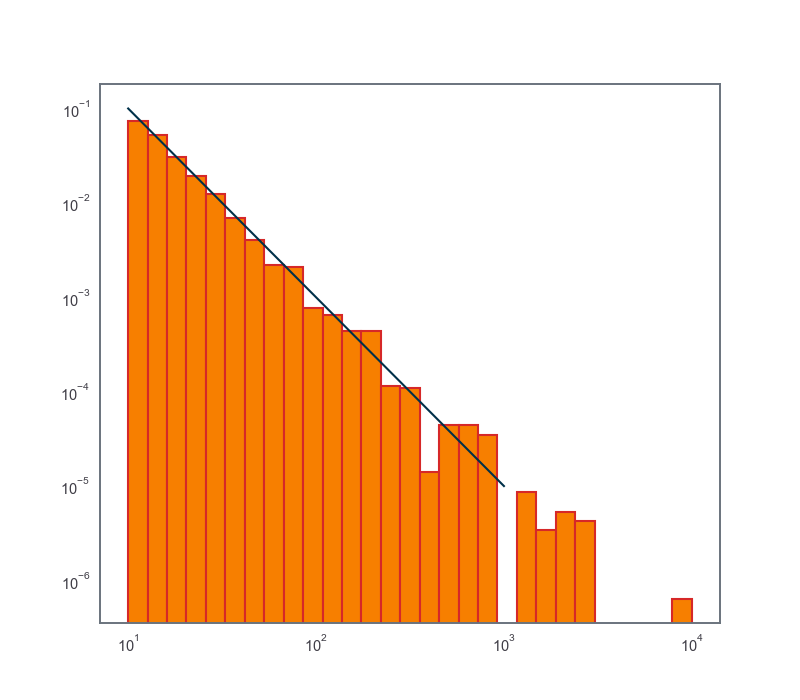

In [28]:
fig, ax = plt.subplots()
bins = np.logspace(np.log10(Lmin_true),4,30)
#ax.hist(data['L_obs'],bins=bins,normed=True)
ax.hist(data['L'],bins=bins,normed=True,facecolor=orange,edgecolor=red,lw=1.5)


ax.plot(data['Lmodel'], phi(data['Lmodel'],alpha=alpha_true,L_min=Lmin_true), color=dark)
#ax.hist(data['L_obs'],bins=bins,normed=False)
ax.set_xscale('log')
ax.set_yscale('log')



<IPython.core.display.Javascript object>


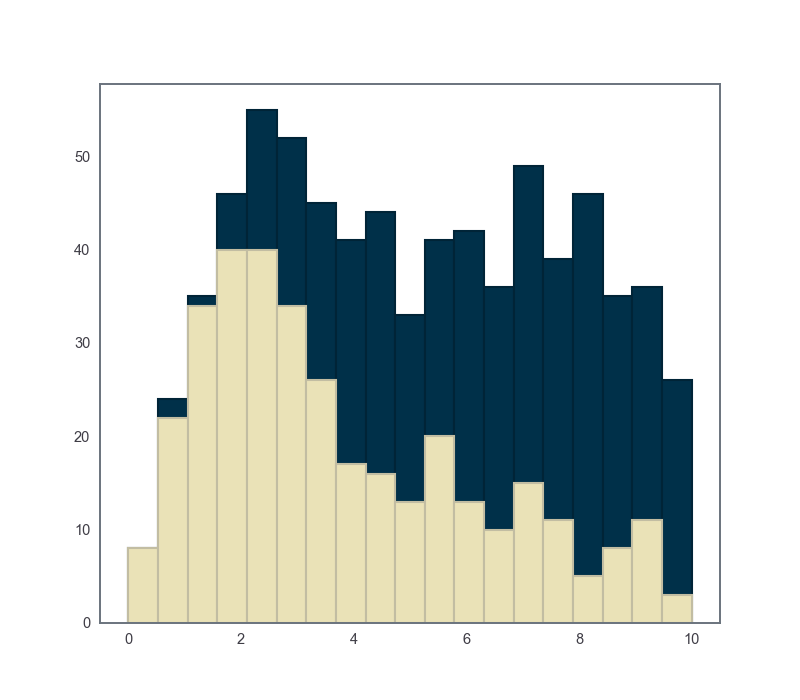

In [29]:
fig, ax = plt.subplots()
bins = np.linspace(0,zmax,20)
plt.hist(data['z'],bins=bins, facecolor=dark, edgecolor=dark_highlight, lw=1.5)
plt.hist(data['z_obs'],bins=bins, facecolor=light, edgecolor=light_highlight, lw=1.5,alpha=1);

<IPython.core.display.Javascript object>


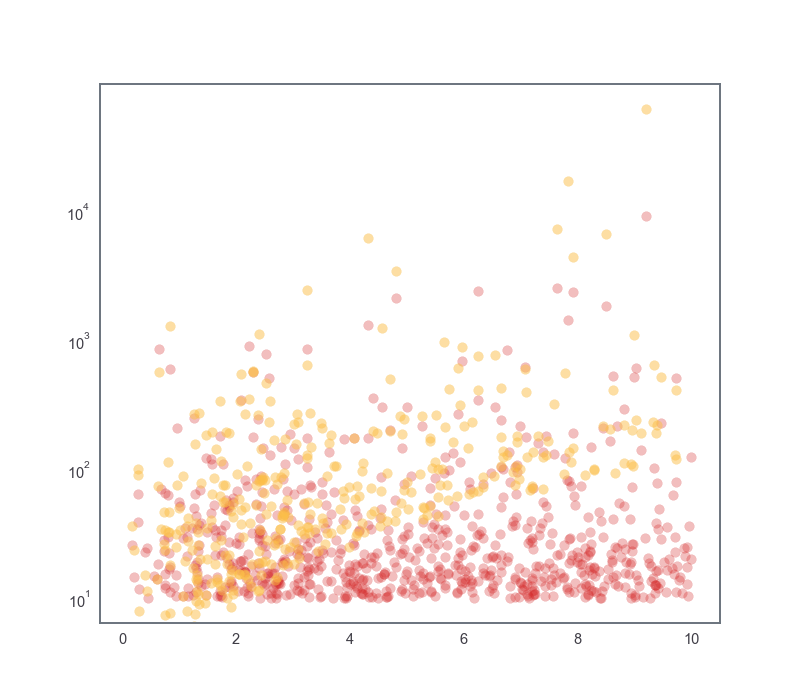

In [30]:
fig, ax = plt.subplots()

ax.scatter(data['z'],data['L'],alpha=.3,color=red)
ax.scatter(data['z_obs'],data['L_obs'],alpha=.5,color=yellow)

ax.set_yscale('log')

In [31]:
model = stan_utility.compile_model('powerlaw_model.stan')

Using cached StanModel


In [33]:
N_margin = 500
data['N_margin'] = N_margin

data['rise'] = rise_true
data['decay'] = decay_true
data['peak'] = peak_true

In [ ]:
n_chain = 4

fit = model.sampling(data=data,iter=8000,chains=n_chain,n_jobs=n_chain ,thin=2)


<IPython.core.display.Javascript object>


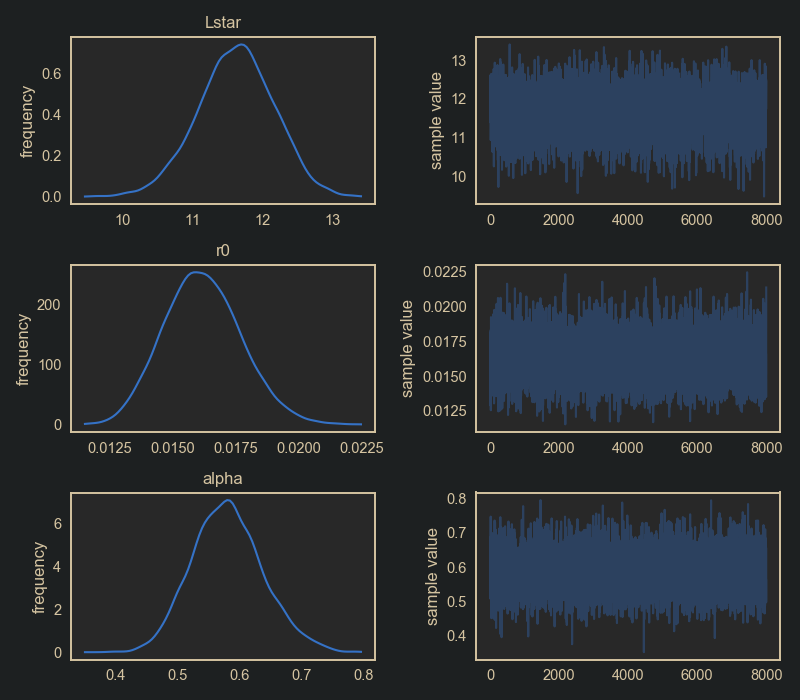

In [179]:
fit.plot(['Lstar','r0','alpha',
         # 'rise','decay', 'peak'
         ]);
plt.tight_layout()

<IPython.core.display.Javascript object>


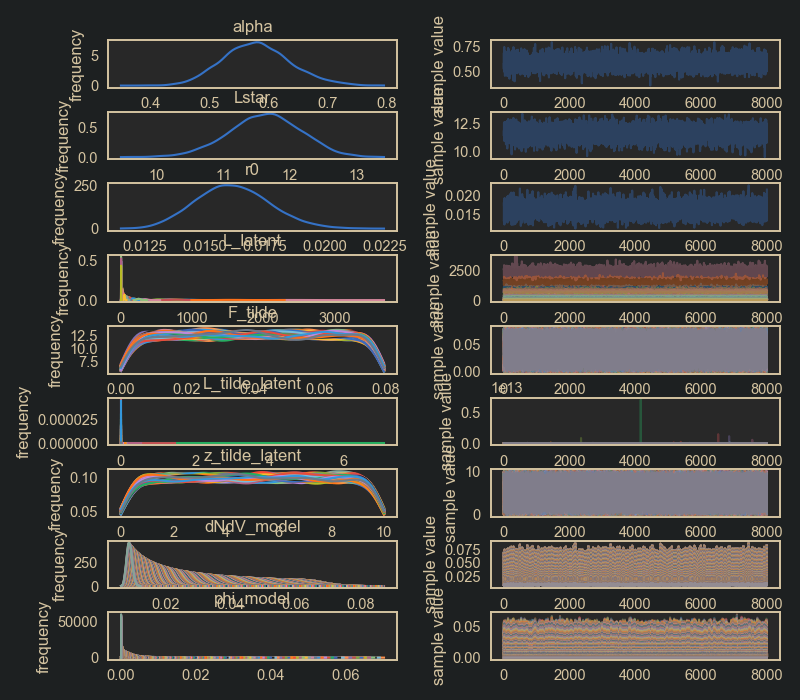

/home/jburgess/.venv/stan/local/lib/python2.7/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


In [180]:
fit.plot();
plt.tight_layout()

<IPython.core.display.Javascript object>


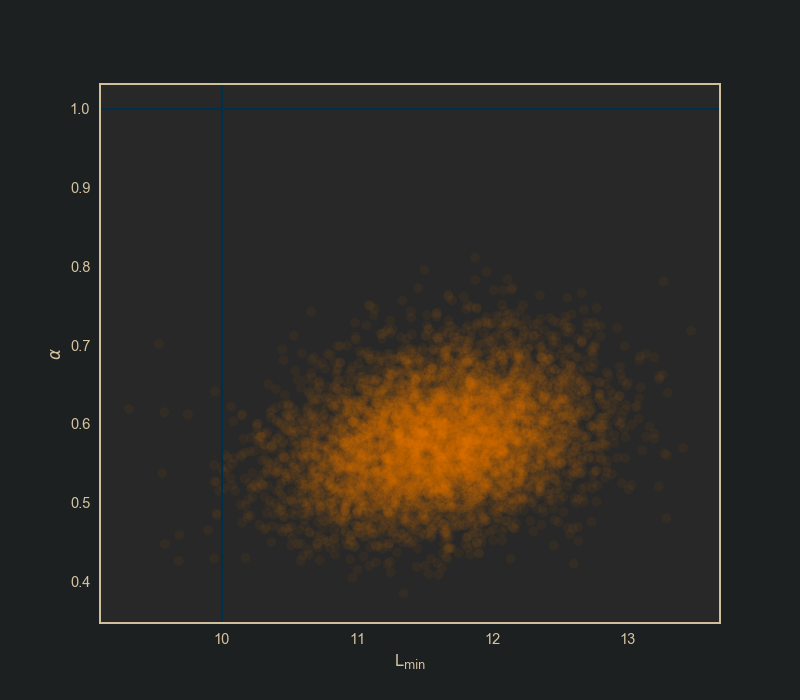

Text(0,0.5,'$\\alpha$')

In [168]:
fig, ax = plt.subplots()


ax.scatter(fit.extract()['Lstar'],
           fit.extract()['alpha'],
           c=orange,
           alpha=0.05,
           edgecolor='none',
           s=50)

ax.axhline(alpha_true,color=dark)
ax.axvline(Lmin_true,color=dark)

ax.set_xlabel(r'L$_{\mathrm{min}}$')
ax.set_ylabel(r'$\alpha$')

<IPython.core.display.Javascript object>


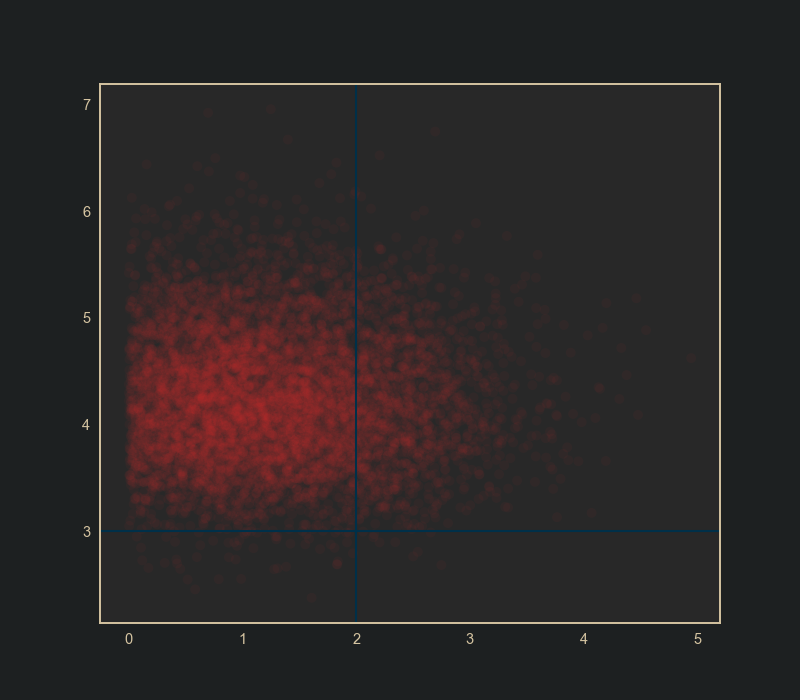

In [59]:
fig, ax = plt.subplots()


ax.scatter(fit.extract()['rise'],
           fit.extract()['decay'],
           c=red,
           alpha=0.05,
           edgecolor='none',
           s=50)
ax.axvline(rise_true,color=dark)
ax.axhline(decay_true,color=dark)

<IPython.core.display.Javascript object>


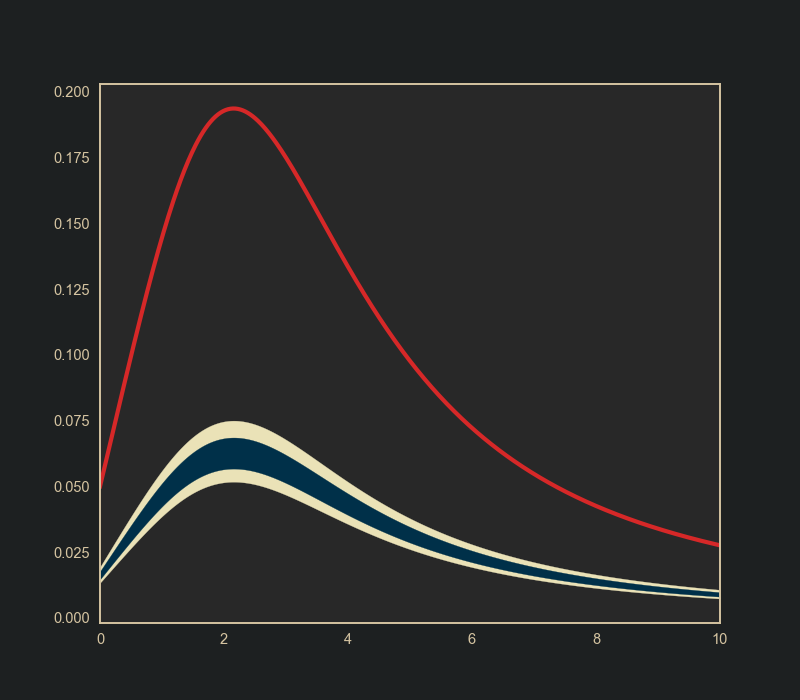

(0, 10)

In [181]:
fig, ax = plt.subplots()

dndzmodel = fit.extract()['dNdV_model']

up = np.percentile(dndzmodel,50 +95./2. ,axis=0)
down = np.percentile(dndzmodel,50 -95./2. ,axis=0)
ax.fill_between(data['zmodel'], down, up, color=light)

up = np.percentile(dndzmodel,50 +68/2 ,axis=0)
down = np.percentile(dndzmodel,50 -68/2 ,axis=0)
ax.fill_between(data['zmodel'], down, up, color=dark)



ax.plot(data['zmodel'], dNdV(data['zmodel'],r0_true,rise_true, decay_true, peak_true),color=red,lw=3)

ax.set_xlim(0,10)

<IPython.core.display.Javascript object>


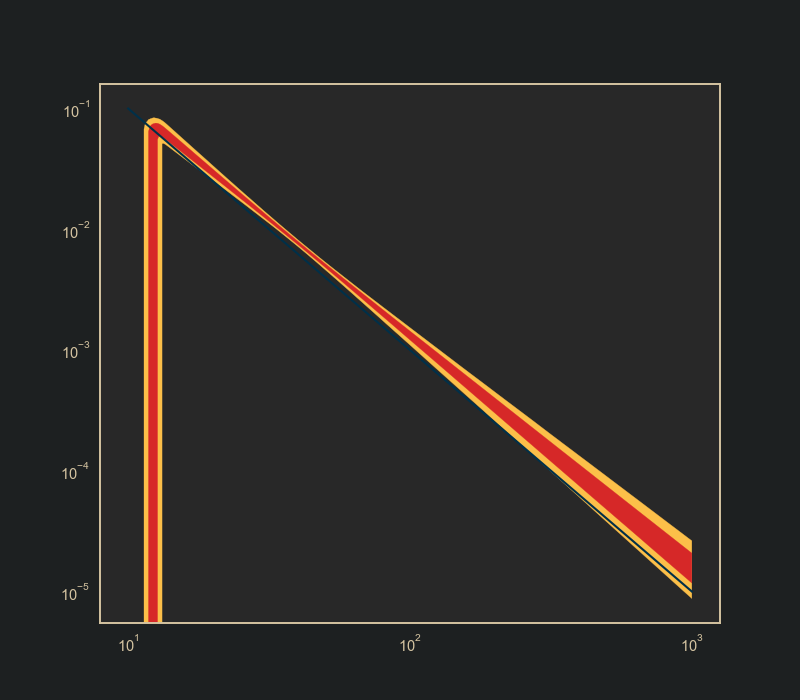

In [123]:
fig, ax = plt.subplots()

phimodel = fit.extract()['phi_model']

up = np.percentile(phimodel,50 +95./2. ,axis=0)
down = np.percentile(phimodel,50 -95./2. ,axis=0)
ax.fill_between(data['Lmodel'], down, up,color=yellow)

up = np.percentile(phimodel,50 +68/2 ,axis=0)
down = np.percentile(phimodel,50 -68/2 ,axis=0)
ax.fill_between(data['Lmodel'], down, up,color=red)
ax.loglog(data['Lmodel'], phi(data['Lmodel'],alpha_true,Lmin_true),color=dark)

